In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [9]:
file_path = r"F:\Xai_traderx\data\processed\axis_processed.csv"
df = pd.read_csv(file_path)

In [10]:
df.head()

,Date,Close,High,Low,Open,Volume,Close_Return_1D,Close_Return_3D,Return,High_Low_Spread,...,bb_upper,bb_lower,bb_width,Bollinger_%B,bear_score,bull_strength,bear_strength,Momentum,Volatility,next_close
0,2020-07-15,424.799133,442.521933,420.916058,422.160635,43250557,0.021427,-0.029459,0.021427,0.050861,...,454.303081,398.685371,0.130407,0.469522,0.0,0.0,0.0,-17.424042,14.353156,432.117218
1,2020-07-16,432.117218,434.257885,416.634689,430.076123,30183647,0.017227,-0.013748,0.017227,0.040783,...,453.637754,402.198291,0.120209,0.581634,0.0,0.0,0.0,-19.664337,14.293742,431.221161
2,2020-07-17,431.221161,437.991649,422.758035,432.117250,33464985,-0.002074,0.036869,-0.002074,0.035327,...,453.762583,403.671502,0.116839,0.549991,0.0,0.0,0.0,-6.471771,12.168083,432.117218
3,2020-07-20,432.117218,440.879030,427.437595,435.801179,30400586,0.002078,0.017227,0.002078,0.031106,...,453.998923,403.818494,0.116996,0.563939,0.0,0.0,0.0,-6.023743,9.547082,444.264313
4,2020-07-21,444.264313,449.043477,436.597705,438.091197,43147019,0.028111,0.028111,0.028111,0.028014,...,454.422846,403.648464,0.118345,0.799928,0.0,0.0,0.0,28.376343,9.983551,476.872223


In [11]:
print(df.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Close_Return_1D',
       'Close_Return_3D', 'Return', 'High_Low_Spread', 'price_gap',
       'return_volatility', 'return_zscore', 'volume_ratio', 'Volume_Z', 'OBV',
       'RSI', 'MACD_Hist', 'ATR', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12',
       'EMA_50', 'bb_upper', 'bb_lower', 'bb_width', 'Bollinger_%B',
       'bear_score', 'bull_strength', 'bear_strength', 'Momentum',
       'Volatility', 'next_close'],
      dtype='object')


We are using features that help the model predict the next day's close price. For selection, we used correlation analysis and feature importance (using SHAP). We also dropped some multicollinear features to reduce redundancy.


In [12]:
selected_features = [
    # Price Action
    'Close', 'High', 'Low', 
    
    # Trends
    'EMA_12', 'EMA_50', 
    
    # Volatility/Volume
    'OBV', 'ATR',
    # Momentum
    'Close_Return_1D','MACD_Hist'
]

In [13]:
df_selected = df[selected_features]

In [14]:
# Separate features and target
features = df_selected
target = df[['next_close']]

In [16]:
# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

# Scale target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

In [17]:
lookback = 4
def create_sequence(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)


X_train_seq, y_train_seq = create_sequence(X_train, y_train, lookback)
X_test_seq, y_test_seq = create_sequence(X_test, y_test, lookback)

In [18]:
# Print shapes of training and testing sequences
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)


Shape of X_train_seq: (945, 4, 9)
Shape of y_train_seq: (945, 1)
Shape of X_test_seq: (234, 4, 9)
Shape of y_test_seq: (234, 1)


Building our model Gated Recurrent Unit

In [19]:
model = Sequential([
    Input(shape=(lookback, X_train_seq.shape[2])),
    GRU(100, return_sequences=True),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
print("Model Builded")

# Compile
optimizer = Nadam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=Huber(), metrics=['mae'])

Model Builded


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 4, 100)         │        33,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,001 (367.19 KB)

 Trainable params: 94,001 (367.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True),
    ModelCheckpoint('axisgru.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=25, min_lr=1e-6)
]

# training
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
    shuffle=False,  
    verbose=1
)
print('training Completed...')


Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0304 - mae: 0.2123 - val_loss: 0.0018 - val_mae: 0.0495 - learning_rate: 1.0000e-04
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0247 - mae: 0.1816 - val_loss: 0.0012 - val_mae: 0.0405 - learning_rate: 1.0000e-04
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - mae: 0.1341 - val_loss: 8.4197e-04 - val_mae: 0.0327 - learning_rate: 1.0000e-04
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - mae: 0.0844 - val_loss: 8.2519e-04 - val_mae: 0.0324 - learning_rate: 1.0000e-04
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - mae: 0.0674 - val_loss: 8.1947e-04 - val_mae: 0.0311 - learning_rate: 1.0000e-04
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0505 - val_loss: 9.6874e-04 - val_mae: 0.0343 - learning_rate: 1.0000e-04
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0496 - val_loss: 9.6565e-04 - val_mae

In [22]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5722e-04 - mae: 0.0232 
Test Loss: 0.0004198678652755916
Test MAE: 0.02170063555240631


In [23]:
y_pred_scaled = model.predict(X_test_seq)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [25]:
# Reshape
y_pred_scaled = y_pred_scaled.reshape(-1, 1)
y_test_seq = y_test_seq.reshape(-1, 1)

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

In [ ]:
#Evalution 
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
percentage_error = (mae / np.mean(y_true)) * 100
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Percentage Error: {percentage_error:.2f}%")


MAE: 19.8907
RMSE: 26.5613
R2 Score: 0.9052
Percentage Error: 1.75%
MAPE: 1.74%


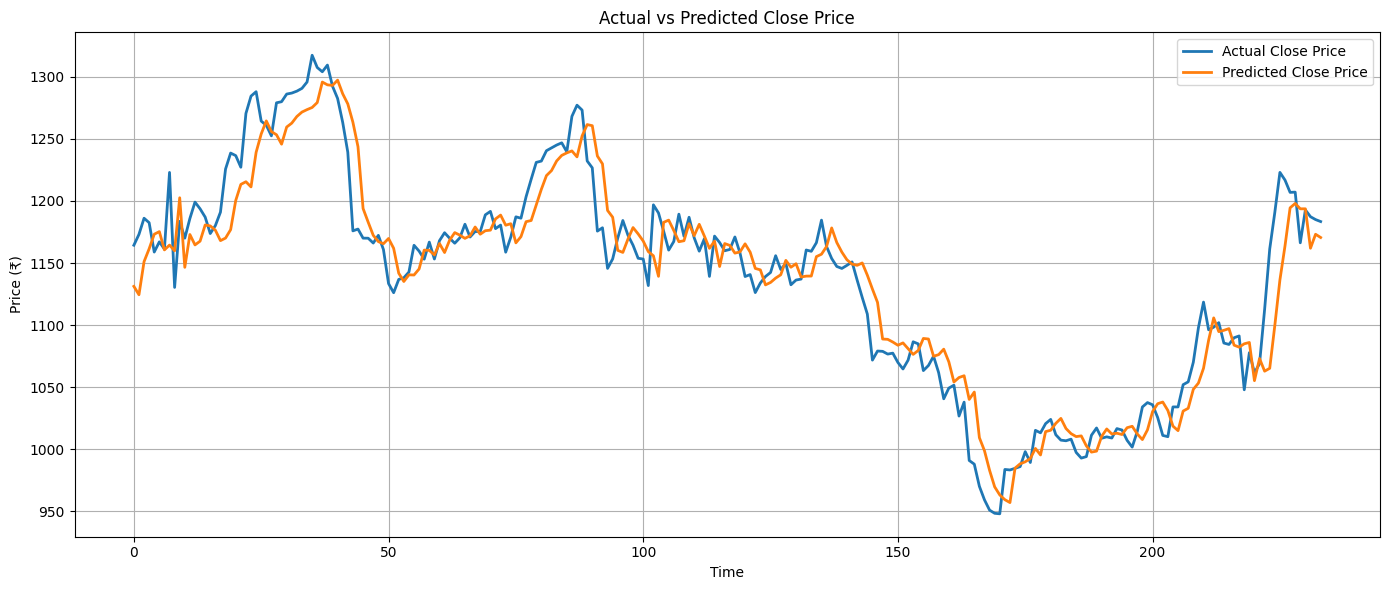

In [40]:
plt.figure(figsize=(14, 6))
plt.plot(y_true, label='Actual Close Price', linewidth=2)
plt.plot(y_pred, label='Predicted Close Price', linewidth=2)
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
result_df= pd.DataFrame({
    'Actual': y_true.flatten(),
    'Predicted': y_pred.flatten()
})

result_df.head()

,Actual,Predicted
0,1164.351440,1131.224487
1,1173.094604,1124.458740
2,1186.084595,1151.134521
3,1182.487427,1161.471313
4,1158.855591,1173.203613


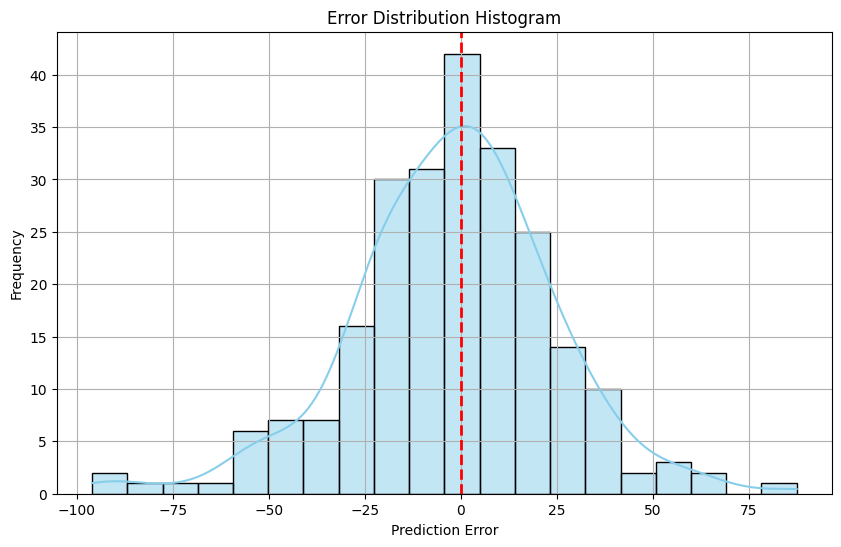

In [42]:
result_df['Error'] = result_df['Predicted'] - result_df['Actual']
plt.figure(figsize=(10, 6))
sns.histplot(result_df['Error'], bins=20, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Error Distribution Histogram')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [44]:
## SHAP

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6625/6625 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step


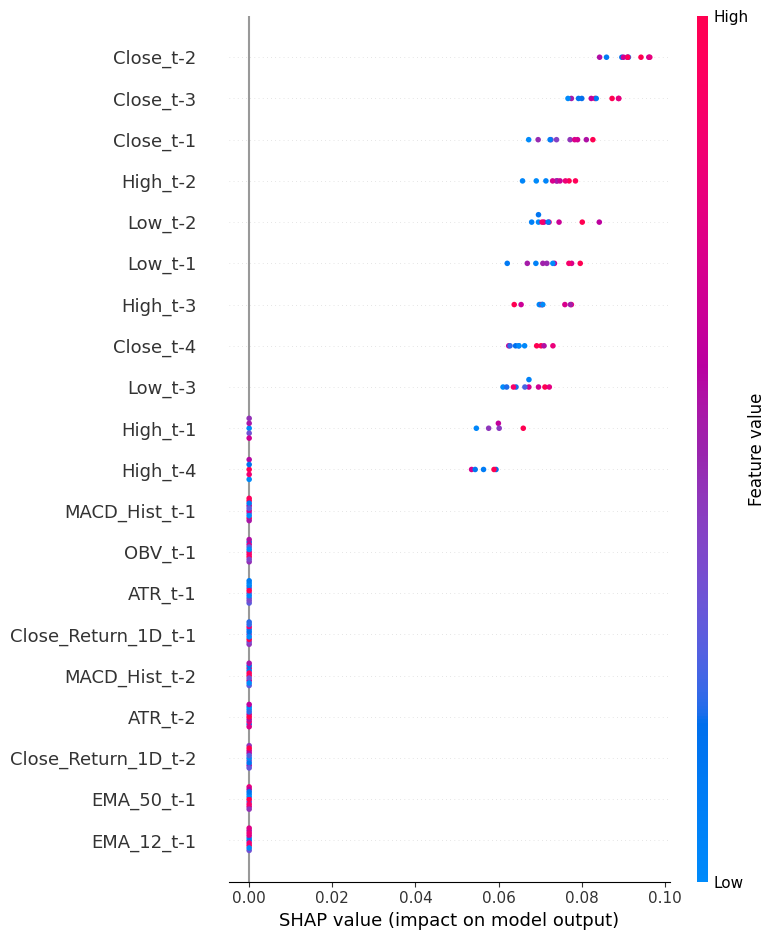

In [ ]:
import shap
# 1. Prepare a sample of your training data (first 100 samples)
background = X_train_seq[:100].reshape(100, -1)  # Flatten time steps

# 2. Create a prediction function that handles GRU input shape
def predict_fn(X):
    return model.predict(X.reshape(-1, lookback, len(selected_features))).flatten()

# 3. Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background)

# 4. Calculate SHAP values for test samples (first 10 samples)
test_samples = X_test_seq[:10].reshape(10, -1)
shap_values = explainer.shap_values(test_samples)

# 5. Plot results
shap.summary_plot(shap_values, 
                 test_samples,
                 feature_names=[f"{feat}_t-{i}" 
                              for i in range(lookback, 0, -1) 
                              for feat in selected_features])

## Based on this shap plot our model predciting based on price action  mainly on close price of last day